In [3]:
!pip install transformers datasets evaluate peft nltk rouge-score bert_score pandas matplotlib seaborn tqdm --quiet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00


In [4]:
# Import essential libraries
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from peft import get_peft_model, LoraConfig, TaskType
import evaluate
from tqdm.auto import tqdm

In [5]:
# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

# Create project directory
!mkdir -p /content/drive/MyDrive/financial_summarization
PROJECT_DIR = '/content/drive/MyDrive/financial_summarization'

Mounted at /content/drive


## Dataset Preparation
Dataset Loading and Analysis

In [12]:
print("Loading CNN/DailyMail dataset...")
dataset = load_dataset("abisee/cnn_dailymail", "3.0.0")
print(f"Dataset loaded: {len(dataset['train'])} train, {len(dataset['validation'])} validation, {len(dataset['test'])} test")

# Examine a few examples
print("\nSample article:")
print(dataset['train'][0]['article'][:500] + "...")
print("\nSample summary:")
print(dataset['train'][0]['highlights'])

Loading CNN/DailyMail dataset...
Dataset loaded: 287113 train, 13368 validation, 11490 test

Sample article:
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as s...

Sample summary:
Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .


## Analyze dataset statistics


Dataset Statistics (train split):
Article Length:
  Mean: 591.62
  Median: 547.00
  Min: 50.00
  Max: 1743.00
  Std: 286.52
Summary Length:
  Mean: 42.77
  Median: 43.00
  Min: 23.00
  Max: 66.00
  Std: 7.55


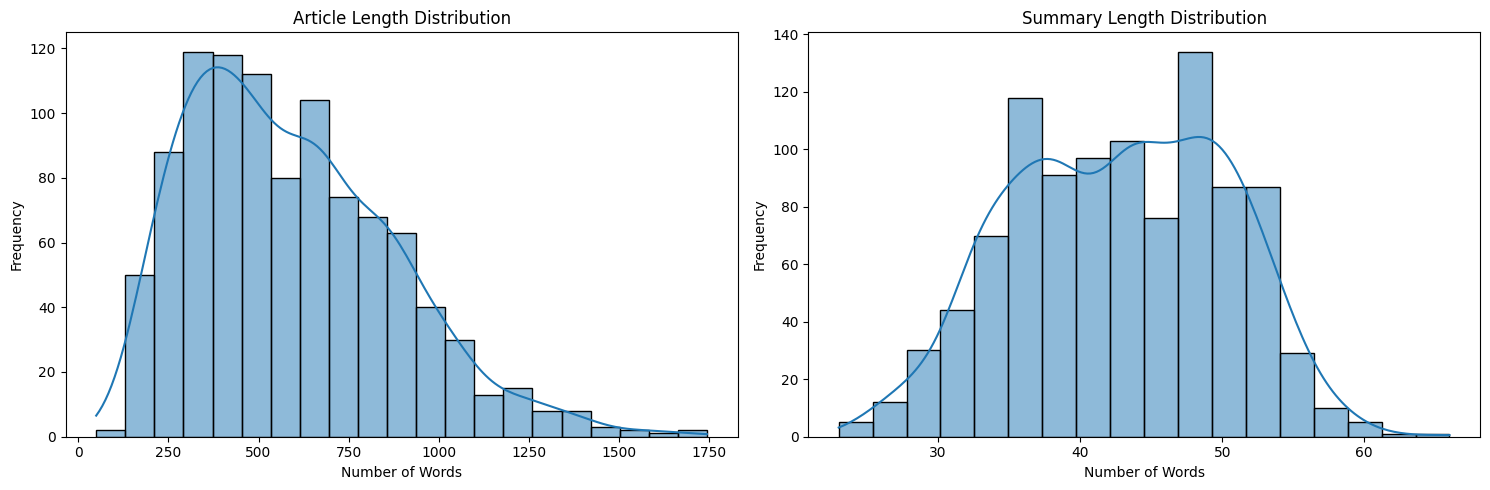

In [13]:
def analyze_dataset_statistics(dataset, split='train', sample_size=1000):
    """Analyze and visualize dataset statistics"""

    # Select a sample for faster processing
    if len(dataset[split]) > sample_size:
        sample = dataset[split].select(range(sample_size))
    else:
        sample = dataset[split]

    # Compute article and summary lengths
    article_lengths = [len(example['article'].split()) for example in sample]
    summary_lengths = [len(example['highlights'].split()) for example in sample]

    # Calculate statistics
    stats = {
        'Article Length': {
            'Mean': np.mean(article_lengths),
            'Median': np.median(article_lengths),
            'Min': np.min(article_lengths),
            'Max': np.max(article_lengths),
            'Std': np.std(article_lengths)
        },
        'Summary Length': {
            'Mean': np.mean(summary_lengths),
            'Median': np.median(summary_lengths),
            'Min': np.min(summary_lengths),
            'Max': np.max(summary_lengths),
            'Std': np.std(summary_lengths)
        }
    }

    print(f"\nDataset Statistics ({split} split):")
    for metric, values in stats.items():
        print(f"{metric}:")
        for stat_name, stat_value in values.items():
            print(f"  {stat_name}: {stat_value:.2f}")

    # Create visualizations
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Article length distribution
    sns.histplot(article_lengths, kde=True, ax=axes[0])
    axes[0].set_title('Article Length Distribution')
    axes[0].set_xlabel('Number of Words')
    axes[0].set_ylabel('Frequency')

    # Summary length distribution
    sns.histplot(summary_lengths, kde=True, ax=axes[1])
    axes[1].set_title('Summary Length Distribution')
    axes[1].set_xlabel('Number of Words')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.savefig(f"{PROJECT_DIR}/dataset_statistics_{split}.png")
    plt.show()

    return stats

# Analyze train split
train_stats = analyze_dataset_statistics(dataset, 'train')

### Finance-Specific Filtering

Define finance keywords

In [16]:
def define_finance_keywords():
    """Define comprehensive financial keyword list"""

    # General financial terms
    general_finance = [
        'stock', 'market', 'investor', 'economy', 'financial', 'economic',
        'bank', 'trading', 'investment', 'profit', 'revenue', 'earnings',
        'fiscal', 'dividend', 'shareholders', 'ceo', 'quarterly', 'hedge',
        'fund', 'debt', 'credit', 'loan', 'mortgage', 'bond', 'yield',
        'interest rate', 'inflation', 'recession', 'gdp', 'growth'
    ]

    # Financial entities and organizations
    organizations = [
        'nasdaq', 'dow jones', 'nyse', 's&p', 'fed', 'federal reserve',
        'sec', 'imf', 'world bank', 'treasury', 'wall street', 'moody',
        'fitch', 'standard & poor', 'bloomberg', 'goldman sachs', 'jpmorgan',
        'morgan stanley', 'citigroup', 'bank of america', 'wells fargo'
    ]

    # Financial metrics and indicators
    metrics = [
        'eps', 'p/e', 'price-to-earnings', 'market cap', 'capitalization',
        'valuation', 'undervalued', 'overvalued', 'bull', 'bear', 'bullish',
        'bearish', 'volatility', 'index', 'benchmark', 'portfolio', 'asset',
        'liability', 'balance sheet', 'income statement', 'cash flow'
    ]

    # Currencies and commodities
    currencies_commodities = [
        'dollar', 'euro', 'yen', 'pound', 'forex', 'currency', 'exchange rate',
        'oil', 'gold', 'silver', 'commodity', 'futures', 'barrel', 'crude'
    ]

    # Earnings & corporate actions
    earnings_actions = [
        'earnings call', 'quarterly results', 'buyback', 'stock split', 'ipo',
        'spinoff', 'guidance', 'outlook', 'forecast', 'merger', 'acquisition',
        'm&a', 'sec filing', '10-k', '10-q', 'report', 'filing', 'upgrade', 'downgrade'
    ]

    # People & roles
    people_roles = [
        'analyst', 'board', 'chairman', 'cfo', 'cio', 'coo', 'founder', 'investor relations'
    ]

    # Market events & trends
    events_trends = [
        'bull run', 'market crash', 'correction', 'bubble', 'slump', 'rally',
        'downturn', 'soft landing', 'tightening', 'easing', 'macroeconomic',
        'stimulus', 'policy rate'
    ]

    # Global & political factors
    global_politics = [
        'tariff', 'sanctions', 'brexit', 'trade war', 'geopolitical', 'central bank', 'opec'
    ]

    # Tech & fintech
    fintech_terms = [
        'blockchain', 'crypto', 'bitcoin', 'ethereum', 'digital currency', 'fintech', 'neobank'
    ]

    # Abbreviations and tickers
    abbreviations = [
        'ipo', 'etf', 'cpi', 'ppi', 'fomc', 'gdp', 'usd', 'eur', 'jpy'
    ]

    # Merge all categories
    all_keywords = (
        general_finance + organizations + metrics + currencies_commodities +
        earnings_actions + people_roles + events_trends + global_politics +
        fintech_terms + abbreviations
    )

    # Add uppercase and title case versions for robustness
    expanded_keywords = all_keywords.copy()
    for keyword in all_keywords:
        expanded_keywords.append(keyword.upper())
        expanded_keywords.append(keyword.title())

    return list(set(expanded_keywords))  # Remove duplicates

# Generate finance keywords
finance_keywords = define_finance_keywords()
print(f"Created list of {len(finance_keywords)} finance keywords")
print("Sample keywords:", finance_keywords[:10])


Created list of 436 finance keywords
Sample keywords: ['crypto', 'financial', 'Stock', 'BUYBACK', 'SANCTIONS', 'cash flow', 'MERGER', 'bloomberg', 'BOARD', 'BLOOMBERG']


#### Create finance filtering function:

In [17]:
def is_finance_related(article, keywords=finance_keywords, min_matches=2):
    """
    Determine if an article is finance-related based on keyword matching

    Args:
        article (str): Article text
        keywords (list): List of finance-related keywords
        min_matches (int): Minimum number of keyword matches required

    Returns:
        bool: True if article is finance-related, False otherwise
    """
    article_lower = article.lower()
    match_count = 0

    for keyword in keywords:
        if keyword.lower() in article_lower:
            match_count += 1
            if match_count >= min_matches:
                return True

    return False

# Test the filter on a few examples
for i in range(5):
    article = dataset['train'][i]['article']
    is_finance = is_finance_related(article)
    print(f"Example {i+1}: {'Finance-related' if is_finance else 'Not finance-related'}")
    if is_finance:
        # Find which keywords matched
        matched = [k for k in finance_keywords if k.lower() in article.lower()]
        print(f"  Matched keywords: {matched[:5]}")

Example 1: Finance-related
  Matched keywords: ['REPORT', 'Report', 'earnings', 'POUND', 'FUND']
Example 2: Not finance-related
Example 3: Finance-related
  Matched keywords: ['SEC', 'Ppi', 'bank', 'Bank', 'Sec']
Example 4: Finance-related
  Matched keywords: ['SEC', 'cio', 'CIO', 'Sec', 'Cio']
Example 5: Finance-related
  Matched keywords: ['REPORT', 'Report', 'SEC', 'fed', 'Fed']


#### Apply finance filter to dataset:

In [18]:
def filter_finance_articles(dataset, split='train', keywords=finance_keywords):
    """Filter dataset for finance-related articles"""

    def is_finance(example):
        return is_finance_related(example['article'], keywords)

    # Apply filter
    filtered_dataset = dataset[split].filter(is_finance)

    print(f"Finance filtering results for {split} split:")
    print(f"  Original size: {len(dataset[split])}")
    print(f"  Filtered size: {len(filtered_dataset)}")
    print(f"  Percentage: {len(filtered_dataset)/len(dataset[split])*100:.2f}%")

    return filtered_dataset

# Filter training set
train_finance = filter_finance_articles(dataset, 'train')
# Filter validation and test sets
val_finance = filter_finance_articles(dataset, 'validation')
test_finance = filter_finance_articles(dataset, 'test')

# Sample up to 4000 examples for training to keep computation manageable
TRAIN_SAMPLE_SIZE = min(4000, len(train_finance))
VAL_SAMPLE_SIZE = min(500, len(val_finance))
TEST_SAMPLE_SIZE = min(500, len(test_finance))

# Create stratified sample (balance longer and shorter articles)
def create_balanced_sample(dataset, size):
    article_lengths = [len(example['article'].split()) for example in dataset]
    # Create bins for article length
    median_length = np.median(article_lengths)
    short_indices = [i for i, length in enumerate(article_lengths) if length <= median_length]
    long_indices = [i for i, length in enumerate(article_lengths) if length > median_length]

    # Sample evenly from short and long articles
    short_sample = np.random.choice(short_indices, size=size//2, replace=False)
    long_sample = np.random.choice(long_indices, size=size//2, replace=False)

    # Combine indices and sort
    combined_indices = sorted(list(short_sample) + list(long_sample))
    return dataset.select(combined_indices)

# Create balanced samples
train_dataset = create_balanced_sample(train_finance, TRAIN_SAMPLE_SIZE)
val_dataset = create_balanced_sample(val_finance, VAL_SAMPLE_SIZE)
test_dataset = create_balanced_sample(test_finance, TEST_SAMPLE_SIZE)

print(f"Final dataset sizes: {len(train_dataset)} train, {len(val_dataset)} validation, {len(test_dataset)} test")

# Save datasets to disk for persistence
train_dataset.save_to_disk(f"{PROJECT_DIR}/train_finance")
val_dataset.save_to_disk(f"{PROJECT_DIR}/val_finance")
test_dataset.save_to_disk(f"{PROJECT_DIR}/test_finance")

Filter:   0%|          | 0/287113 [00:00<?, ? examples/s]

Finance filtering results for train split:
  Original size: 287113
  Filtered size: 270593
  Percentage: 94.25%


Filter:   0%|          | 0/13368 [00:00<?, ? examples/s]

Finance filtering results for validation split:
  Original size: 13368
  Filtered size: 12333
  Percentage: 92.26%


Filter:   0%|          | 0/11490 [00:00<?, ? examples/s]

Finance filtering results for test split:
  Original size: 11490
  Filtered size: 10565
  Percentage: 91.95%
Final dataset sizes: 4000 train, 500 validation, 500 test


Saving the dataset (0/1 shards):   0%|          | 0/4000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

# Data Cleaning and Preprocessing

#### Define preprocessing functions

In [28]:
def preprocess_example(example):
    """Clean text by removing extra spaces and fixing punctuation"""

    # Clean article text
    article = ' '.join(example["article"].split())

    # Clean summary text
    summary = ' '.join(example["highlights"].split())

    # Fix spacing around punctuation
    for punct in ['.', ',', '!', '?', ';', ':', '%']:
        article = article.replace(f" {punct}", punct)
        summary = summary.replace(f" {punct}", punct)

    # Normalize financial symbols
    # Replace variations of USD with consistent format
    article = article.replace("$", " $ ")
    article = article.replace("US$", " $ ")
    article = article.replace("USD", " $ ")

    summary = summary.replace("$", " $ ")
    summary = summary.replace("US$", " $ ")
    summary = summary.replace("USD", " $ ")

    # Clean up excess whitespace
    article = ' '.join(article.split())
    summary = ' '.join(summary.split())

    return {
        "article": article.strip(),
        "summary": summary.strip(),
        "id": example["id"]
    }

# Apply preprocessing to all datasets
print("Preprocessing datasets...")
train_dataset = train_dataset.map(preprocess_example)
val_dataset = val_dataset.map(preprocess_example)
test_dataset = test_dataset.map(preprocess_example)

# Check a preprocessed example
print("\nPreprocessed example:")
print("Article (first 200 chars):", train_dataset[0]["article"][:200] + "...")
print("Summary:", train_dataset[0]["summary"])

Preprocessing datasets...


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]


Preprocessed example:
Article (first 200 chars): reuters is a global information company providing material tailored for professionals in the financial services, media and corporate markets. its information is trusted and drives decision making acro...
Summary: Reuters was founded in 1851 by Julius Reuter, transmitting market quotations. The company was first in Europe with news of President Lincoln's assassination. Today Reuters has 196 bureaux serving approximately 131 countries.


#### Analyze financial entity distribution:


Financial Entity Analysis (train split, sample of 100):
  percentage: 31 occurrences (0.31 per article)
    Examples: ['25 percent', '25 percent', '11 percent', '100 percent', '90 percent']
  dollar_amount: 105 occurrences (1.05 per article)
    Examples: ['$ 275,000', '$ 4 million', '$ 350,000', '1 million', '2.7 million']
  financial_year: 1 occurrences (0.01 per article)
    Examples: ['q400']
  growth_rate: 1 occurrences (0.01 per article)
    Examples: ['11 percent increase']


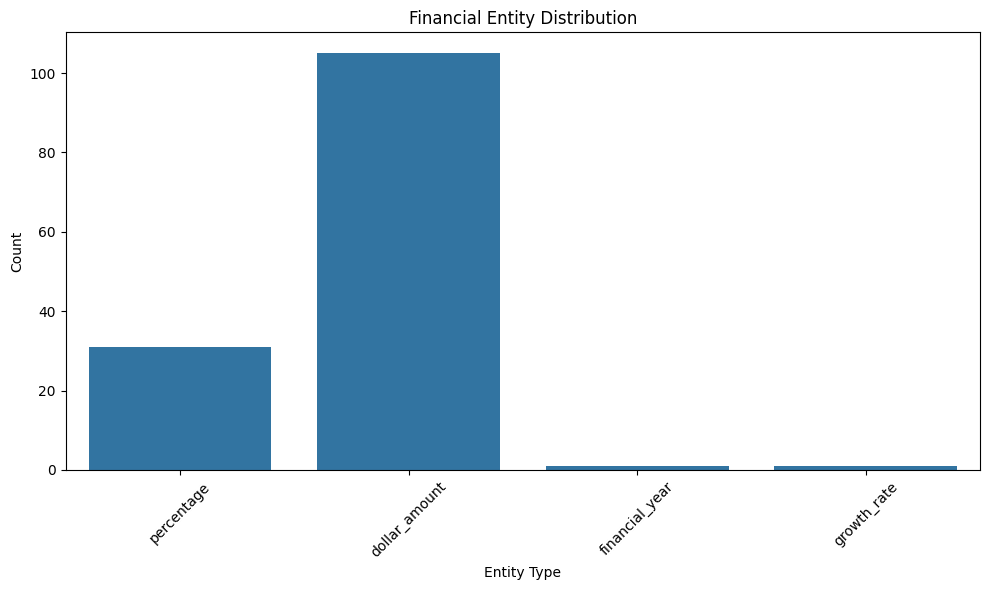

In [46]:
import re
import matplotlib.pyplot as plt
import seaborn as sns

def extract_financial_entities(dataset, split='train', sample_size=100):
    """Extract and analyze financial entities in the dataset"""

    # Sample dataset
    if len(dataset) > sample_size:
        sample = dataset.select(range(sample_size))
    else:
        sample = dataset

    # Refined regex patterns for financial entity detection
    patterns = {
        'percentage': r'\d+(?:\.\d+)?(?:\s*(?:%|percent|per cent|pct)\b)',
        'dollar_amount': r'(?:(?:\$|USD|€|GBP|¥)\s?)\d+(?:,\d+)*(?:\.\d+)?(?:\s?(?:million|billion|trillion))?\b|\b\d+(?:,\d+)*(?:\.\d+)?\s?(?:million|billion|trillion)\b',
        'financial_year': r'\b(?:FY\s?\d{2,4}|(?:Q[1-4]|[Ff]irst|[Ss]econd|[Tt]hird|[Ff]ourth|[1-4](?:st|nd|rd|th))\s+[Qq]uarter(?:,)?\s+\d{2,4}|Q[1-4][ -]?\d{2,4})\b',
        'growth_rate': r'(?:(?:growth|increase|decline|decrease|drop|rise|gain)(?:\s+(?:by|at\s+a\s+rate\s+of))?\s+\d+(?:\.\d+)?(?:\s*(?:%|percent|per cent|pct)\b)|\b\d+(?:\.\d+)?(?:\s*(?:%|percent|per cent|pct)\b)\s+(?:growth|increase|decline|decrease|drop|rise|gain)\b)'
    }

    # Init tracking
    entity_counts = {entity_type: 0 for entity_type in patterns}
    entity_examples = {entity_type: [] for entity_type in patterns}

    for example in sample:
        article = example['article']
        for entity_type, pattern in patterns.items():
            matches = re.findall(pattern, article, flags=re.IGNORECASE)
            entity_counts[entity_type] += len(matches)
            if len(entity_examples[entity_type]) < 5 and matches:
                remaining = 5 - len(entity_examples[entity_type])
                entity_examples[entity_type].extend(matches[:remaining])

    # Output summary
    print(f"\nFinancial Entity Analysis ({split} split, sample of {len(sample)}):")
    for entity_type, count in entity_counts.items():
        print(f"  {entity_type}: {count} occurrences ({count/len(sample):.2f} per article)")
        if entity_examples[entity_type]:
            print(f"    Examples: {entity_examples[entity_type]}")

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()))
    plt.title('Financial Entity Distribution')
    plt.xlabel('Entity Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{PROJECT_DIR}/financial_entities_{split}.png")
    plt.show()

    return entity_counts, entity_examples

# Analyze financial entities in training set
train_entities, train_entity_examples = extract_financial_entities(train_dataset)


Financial Entity Analysis (train split, sample of 100):
  percentage: 2 occurrences (0.02 per article)
    Examples: ['90%', '10%']
  dollar_amount: 90 occurrences (0.90 per article)
    Examples: ['$ 275,000', '$ 4 million', '$ 350,000', '$ 250', '$ 300']
  financial_year: 1 occurrences (0.01 per article)
    Examples: ['q400']
  growth_rate: 0 occurrences (0.00 per article)


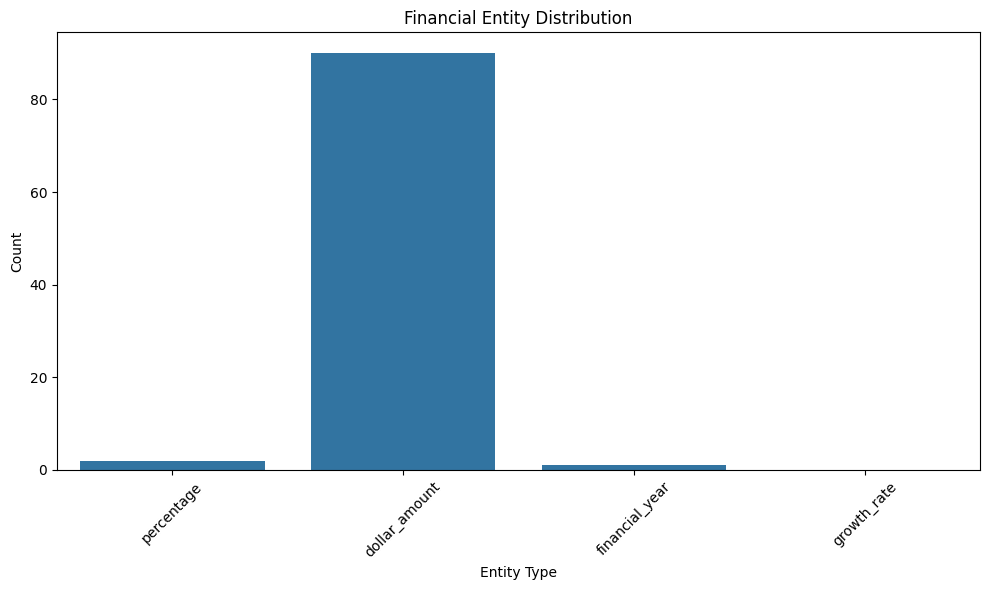

In [44]:
def extract_financial_entities(dataset, split='train', sample_size=100):
    """Extract and analyze financial entities in the dataset"""

    # Sample dataset
    if len(dataset) > sample_size:
        sample = dataset.select(range(sample_size))
    else:
        sample = dataset

    # Refined regex patterns for financial entity detection
    patterns = {
        'percentage': r'\d+(?:\.\d+)?%',
        'dollar_amount': r'\$\s?\d+(?:,\d+)*(?:\.\d+)?(?:\s?(?:million|billion|trillion))?',
        'financial_year': r'\b(?:FY\s?\d{2,4}|Q[1-4][ -]?\d{2,4})\b',
        'growth_rate': r'(?:growth|increase|decline|decrease|drop|rise|gain)(?:\s+by)?\s+\d+(?:\.\d+)?%'
    }

    # Init tracking
    entity_counts = {entity_type: 0 for entity_type in patterns}
    entity_examples = {entity_type: [] for entity_type in patterns}

    for example in sample:
        article = example['article']
        for entity_type, pattern in patterns.items():
            matches = re.findall(pattern, article, flags=re.IGNORECASE)
            entity_counts[entity_type] += len(matches)
            if len(entity_examples[entity_type]) < 5 and matches:
                remaining = 5 - len(entity_examples[entity_type])
                entity_examples[entity_type].extend(matches[:remaining])

    # Output summary
    print(f"\nFinancial Entity Analysis ({split} split, sample of {len(sample)}):")
    for entity_type, count in entity_counts.items():
        print(f"  {entity_type}: {count} occurrences ({count/len(sample):.2f} per article)")
        if entity_examples[entity_type]:
            print(f"    Examples: {entity_examples[entity_type]}")

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()))
    plt.title('Financial Entity Distribution')
    plt.xlabel('Entity Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{PROJECT_DIR}/financial_entities_{split}.png")
    plt.show()

    return entity_counts, entity_examples

    # Analyze financial entities in training set
train_entities, train_entity_examples = extract_financial_entities(train_dataset)



Financial Entity Analysis (train split, sample of 100):
  percentage: 2 occurrences (0.02 per article)
    Examples: ['90%', '10%']
  dollar_amount: 90 occurrences (0.90 per article)
    Examples: ['$ 275,000', '$ 4 million', '$ 350,000', '$ 250', '$ 300']
  financial_year: 0 occurrences (0.00 per article)
  growth_rate: 2 occurrences (0.02 per article)
    Examples: ['90%', '10%']


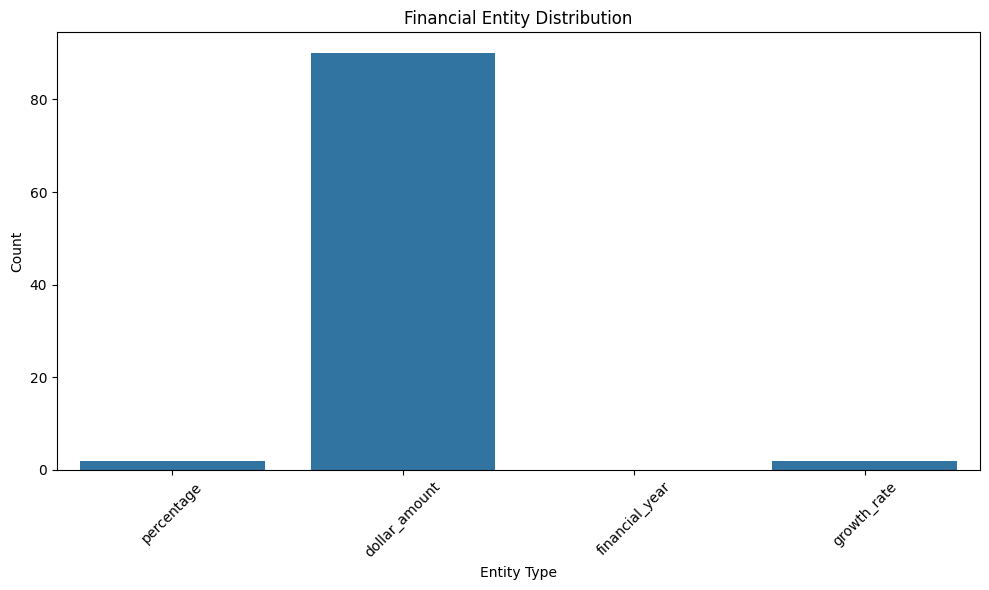

In [47]:
def extract_financial_entities(dataset, split='train', sample_size=100):
    """Extract and analyze financial entities in the dataset"""

    # Select sample for analysis
    if len(dataset) > sample_size:
        sample = dataset.select(range(sample_size))
    else:
        sample = dataset

    # Define financial entity patterns
    import re

    patterns = {
        'percentage': r'\d+(?:\.\d+)?%',
        'dollar_amount': r'\$\s?\d+(?:,\d+)*(?:\.\d+)?(?:\s?(?:million|billion|trillion))?',
        'financial_year': r'(?:FY\s?\d{2,4}|Q[1-4]\s?\d{4})',
        # 'financial_year': r'(?:FY|Q[1-4])[-\s]?\d{2,4}',
        'growth_rate': r'(?:(?:growth|increase|decline|decrease|drop|rise|gain)[\w\s]{0,10})?\d+(?:\.\d+)?%',

        # 'growth_rate': r'(?:grew|increased|decreased|declined|dropped)(?:\s+by)?\s+\d+(?:\.\d+)?%',
    }

    entity_counts = {entity_type: 0 for entity_type in patterns}
    entity_examples = {entity_type: [] for entity_type in patterns}

    for example in sample:
        article = example['article']
        for entity_type, pattern in patterns.items():
            matches = re.findall(pattern, article)
            entity_counts[entity_type] += len(matches)
            entity_examples[entity_type].extend(matches[:5])  # Store up to 5 examples

    print(f"\nFinancial Entity Analysis ({split} split, sample of {len(sample)}):")
    for entity_type, count in entity_counts.items():
        print(f"  {entity_type}: {count} occurrences ({count/len(sample):.2f} per article)")
        if entity_examples[entity_type]:
            print(f"    Examples: {entity_examples[entity_type][:5]}")

    # Create visualization
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()))
    plt.title('Financial Entity Distribution')
    plt.xlabel('Entity Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{PROJECT_DIR}/financial_entities_{split}.png")
    plt.show()

    return entity_counts, entity_examples

# Analyze financial entities in training set
train_entities, train_entity_examples = extract_financial_entities(train_dataset)

#### Save preprocessed datasets:

In [49]:
import shutil
import os
from datasets import Dataset

# Define PROJECT_DIR (ensure this matches your setup)
PROJECT_DIR = "/content/drive/MyDrive/financial_summarization"

# Ensure the save directories don't exist or clear them
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f"Cleared existing directory: {directory}")
    os.makedirs(directory, exist_ok=True)
    print(f"Created directory: {directory}")

# Save final preprocessed datasets
print("Saving preprocessed datasets...")

# Clear existing directories
for split in ['train_finance_preprocessed', 'val_finance_preprocessed', 'test_finance_preprocessed']:
    save_path = f"{PROJECT_DIR}/{split}"
    clear_directory(save_path)

# Create fresh copies of the datasets to break cache linkage
train_dataset_copy = Dataset.from_dict(train_dataset.to_dict())
val_dataset_copy = Dataset.from_dict(val_dataset.to_dict())
test_dataset_copy = Dataset.from_dict(test_dataset.to_dict())

# Save the fresh copies
train_dataset_copy.save_to_disk(f"{PROJECT_DIR}/train_finance_preprocessed")
val_dataset_copy.save_to_disk(f"{PROJECT_DIR}/val_finance_preprocessed")
test_dataset_copy.save_to_disk(f"{PROJECT_DIR}/test_finance_preprocessed")
print("Datasets saved successfully!")

# Save dataset statistics and analysis results
import json

analysis_results = {
    'dataset_stats': {
        'train': {
            'size': len(train_dataset),
            'article_mean_length': train_stats['Article Length']['Mean'],
            'summary_mean_length': train_stats['Summary Length']['Mean'],
        },
        'validation': {
            'size': len(val_dataset),
        },
        'test': {
            'size': len(test_dataset),
        }
    },
    'financial_entities': {
        entity_type: count for entity_type, count in zip(train_entities.keys(), train_entities.values())
    },
    'preprocessing': {
        'finance_keywords_used': len(finance_keywords),
        'original_train_size': len(dataset['train']),
        'finance_filtered_size': len(train_finance),
        'finance_percentage': len(train_finance)/len(dataset['train'])*100
    }
}

with open(f"{PROJECT_DIR}/dataset_analysis.json", 'w') as f:
    json.dump(analysis_results, f, indent=2)

print("Phase 1 completed! Dataset prepared and analyzed.")

Saving preprocessed datasets...
Cleared existing directory: /content/drive/MyDrive/financial_summarization/train_finance_preprocessed
Created directory: /content/drive/MyDrive/financial_summarization/train_finance_preprocessed
Cleared existing directory: /content/drive/MyDrive/financial_summarization/val_finance_preprocessed
Created directory: /content/drive/MyDrive/financial_summarization/val_finance_preprocessed
Cleared existing directory: /content/drive/MyDrive/financial_summarization/test_finance_preprocessed
Created directory: /content/drive/MyDrive/financial_summarization/test_finance_preprocessed


Saving the dataset (0/1 shards):   0%|          | 0/4000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

Datasets saved successfully!
Phase 1 completed! Dataset prepared and analyzed.


# Exploratory Data Visualization

#### Explore article-summary relationship

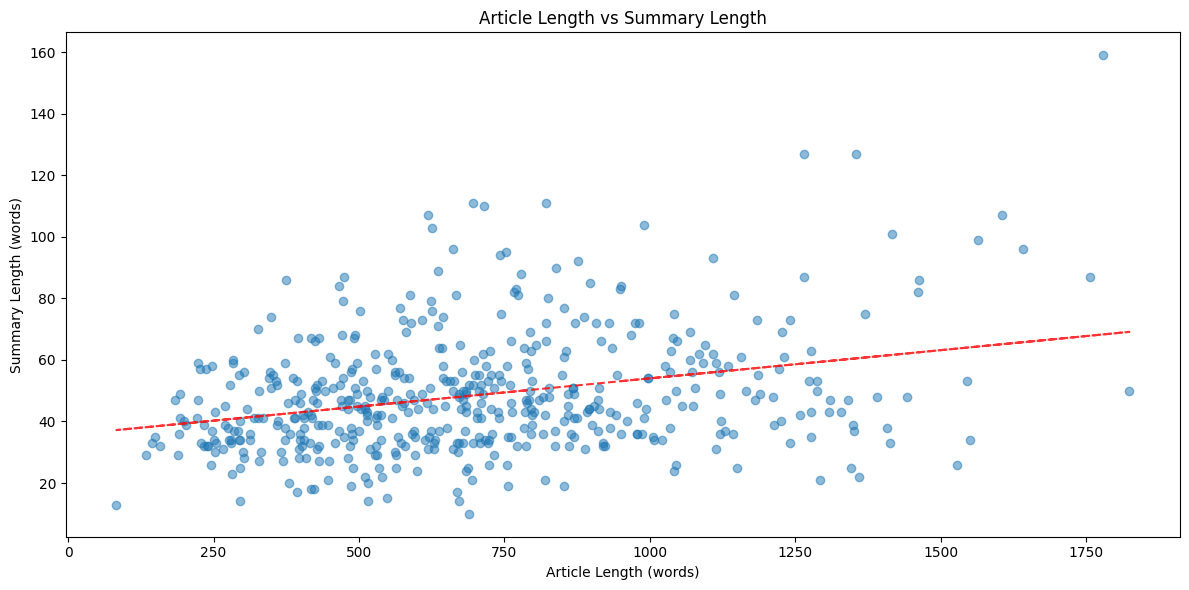

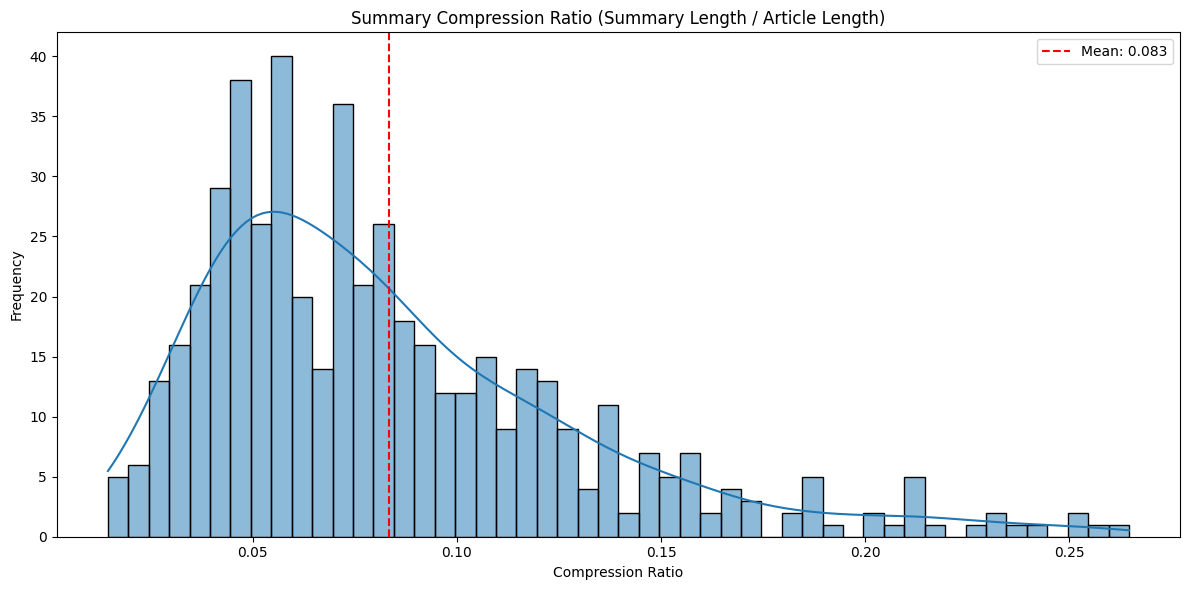

Article-Summary Relationship Stats: {'mean_compression_ratio': np.float64(0.08342971528784072), 'median_compression_ratio': np.float64(0.07326309888386268), 'correlation': np.float64(0.3060950346600001)}


In [50]:
def visualize_article_summary_relationship(dataset, sample_size=500):
    """Visualize relationship between article and summary lengths"""

    # Select sample
    if len(dataset) > sample_size:
        indices = np.random.choice(len(dataset), size=sample_size, replace=False)
        sample = dataset.select(indices)
    else:
        sample = dataset

    # Compute lengths
    article_lengths = [len(example['article'].split()) for example in sample]
    summary_lengths = [len(example['summary'].split()) for example in sample]
    compression_ratios = [s/a if a > 0 else 0 for s, a in zip(summary_lengths, article_lengths)]

    # Create scatter plot
    plt.figure(figsize=(12, 6))
    plt.scatter(article_lengths, summary_lengths, alpha=0.5)
    plt.title('Article Length vs Summary Length')
    plt.xlabel('Article Length (words)')
    plt.ylabel('Summary Length (words)')

    # Add trend line
    z = np.polyfit(article_lengths, summary_lengths, 1)
    p = np.poly1d(z)
    plt.plot(article_lengths, p(article_lengths), "r--", alpha=0.8)

    plt.tight_layout()
    plt.savefig(f"{PROJECT_DIR}/article_summary_relationship.png")
    plt.show()

    # Compression ratio histogram
    plt.figure(figsize=(12, 6))
    sns.histplot(compression_ratios, bins=50, kde=True)
    plt.title('Summary Compression Ratio (Summary Length / Article Length)')
    plt.xlabel('Compression Ratio')
    plt.ylabel('Frequency')
    plt.axvline(np.mean(compression_ratios), color='red', linestyle='--',
               label=f'Mean: {np.mean(compression_ratios):.3f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{PROJECT_DIR}/compression_ratio.png")
    plt.show()

    return {
        'mean_compression_ratio': np.mean(compression_ratios),
        'median_compression_ratio': np.median(compression_ratios),
        'correlation': np.corrcoef(article_lengths, summary_lengths)[0, 1]
    }

# Analyze article-summary relationship
relationship_stats = visualize_article_summary_relationship(train_dataset)
print("Article-Summary Relationship Stats:", relationship_stats)

#### Prepare a dataset report

In [51]:
def generate_dataset_report(train_dataset, val_dataset, test_dataset, train_stats, relationship_stats):
    """Generate comprehensive dataset report with findings"""

    report = f"""
# Financial News Summarization Dataset Report

## Dataset Overview

- **Source**: CNN/DailyMail dataset filtered for financial content
- **Size**:
    - Training: {len(train_dataset)} examples
    - Validation: {len(val_dataset)} examples
    - Test: {len(test_dataset)} examples
- **Finance Filtering**: Used {len(finance_keywords)} financial keywords, requiring at least 2 matches

## Data Characteristics

### Article Statistics
- Mean Length: {train_stats['Article Length']['Mean']:.2f} words
- Median Length: {train_stats['Article Length']['Median']:.2f} words
- Min Length: {train_stats['Article Length']['Min']:.2f} words
- Max Length: {train_stats['Article Length']['Max']:.2f} words

### Summary Statistics
- Mean Length: {train_stats['Summary Length']['Mean']:.2f} words
- Median Length: {train_stats['Summary Length']['Median']:.2f} words
- Min Length: {train_stats['Summary Length']['Min']:.2f} words
- Max Length: {train_stats['Summary Length']['Max']:.2f} words

### Article-Summary Relationship
- Mean Compression Ratio: {relationship_stats['mean_compression_ratio']:.3f}
- Correlation between Article and Summary Length: {relationship_stats['correlation']:.3f}

## Financial Content Analysis

### Financial Entity Distribution
"""

    for entity_type, count in train_entities.items():
        report += f"- {entity_type}: {count} occurrences ({count/len(train_dataset):.2f} per article)\n"

    report += """
## Preprocessing Steps

1. Filtered for finance-related content using keyword matching
2. Removed duplicate whitespace and normalized text
3. Fixed punctuation spacing
4. Normalized financial symbols (e.g., standardized $ formats)
5. Created balanced samples with respect to article length

## Implications for Model Training

- The average summary is approximately {relationship_stats['mean_compression_ratio']:.1%} of the article length
- Based on length distributions, we should set maximum input length to 512 tokens
- For output/summary length, 128 tokens should be sufficient for most examples
- Financial entities (percentages, dollar amounts) should be preserved in summaries
"""

    # Save report to file
    with open(f"{PROJECT_DIR}/dataset_report.md", 'w') as f:
        f.write(report)

    print("Dataset report generated and saved to:", f"{PROJECT_DIR}/dataset_report.md")
    return report

# Generate comprehensive report
dataset_report = generate_dataset_report(train_dataset, val_dataset, test_dataset,
                                       train_stats, relationship_stats)
print("\nDataset Report Preview:")
print(dataset_report[:500] + "...")

Dataset report generated and saved to: /content/drive/MyDrive/financial_summarization/dataset_report.md

Dataset Report Preview:

# Financial News Summarization Dataset Report

## Dataset Overview

- **Source**: CNN/DailyMail dataset filtered for financial content
- **Size**: 
    - Training: 4000 examples
    - Validation: 500 examples
    - Test: 500 examples
- **Finance Filtering**: Used 436 financial keywords, requiring at least 2 matches

## Data Characteristics

### Article Statistics
- Mean Length: 591.62 words
- Median Length: 547.00 words
- Min Length: 50.00 words
- Max Length: 1743.00 words

### Summary Statisti...


# Model Selection & Fine-Tuning Setup

## Model Selection & Analysis

Phase 2: Model Selection & Fine-Tuning Setup
Loaded preprocessed datasets: 4000 train, 500 validation, 500 test

Financial Content Analysis:
Average financial entity density: 2.02 entities per 100 words
- numbers: 1369 occurrences (13.69 per document)
  Examples: ['29', '16', '23', '2', '0']
- percentages: 4 occurrences (0.04 per document)
  Examples: ['10%', '2%', '1%', '94%']
- money: 0 occurrences (0.00 per document)
- company_names: 0 occurrences (0.00 per document)
- dates: 0 occurrences (0.00 per document)


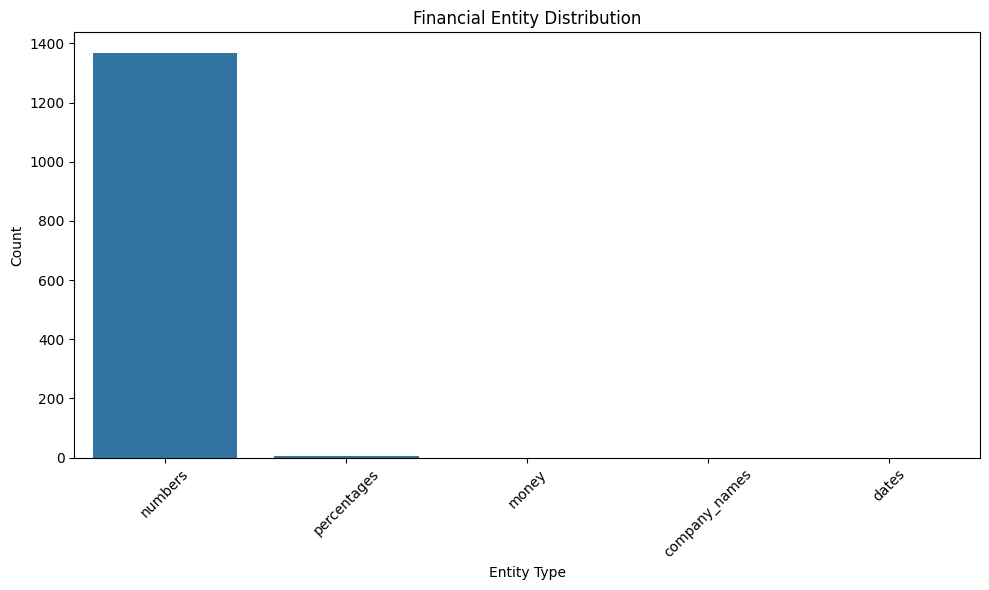

In [52]:
print("Phase 2: Model Selection & Fine-Tuning Setup")

# Load preprocessed datasets
from datasets import load_from_disk

train_dataset = load_from_disk(f"{PROJECT_DIR}/train_finance_preprocessed")
val_dataset = load_from_disk(f"{PROJECT_DIR}/val_finance_preprocessed")
test_dataset = load_from_disk(f"{PROJECT_DIR}/test_finance_preprocessed")

print(f"Loaded preprocessed datasets: {len(train_dataset)} train, {len(val_dataset)} validation, {len(test_dataset)} test")

# Analyze financial content for model selection
def analyze_financial_content(dataset, sample_size=100):
    """Analyze financial content to inform model selection"""
    import re
    from collections import Counter

    # Sample dataset for analysis
    if len(dataset) > sample_size:
        indices = np.random.choice(len(dataset), size=sample_size, replace=False)
        sample = dataset.select(indices)
    else:
        sample = dataset

    # Define financial patterns
    financial_patterns = {
        'numbers': r'\d+(?:\.\d+)?',
        'percentages': r'\d+(?:\.\d+)?%',
        'money': r'<MONEY>',  # Our preprocessed tag
        'company_names': r'(?:[A-Z][a-z]*\s){1,3}(?:Inc\.|Corp\.|LLC|Ltd\.)',
        'dates': r'\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{1,2}\s(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\w*\s\d{2,4}'
    }

    # Count occurrences
    pattern_counts = {k: 0 for k in financial_patterns}
    entity_examples = {k: [] for k in financial_patterns}

    # Analyze article texts
    article_financial_density = []
    for example in sample:
        article = example['article']
        total_count = 0

        for name, pattern in financial_patterns.items():
            matches = re.findall(pattern, article)
            count = len(matches)
            pattern_counts[name] += count
            total_count += count

            # Store examples (up to 5 per pattern)
            if len(entity_examples[name]) < 5 and matches:
                entity_examples[name].extend(matches[:5-len(entity_examples[name])])

        # Calculate financial entity density (entities per 100 words)
        words = len(article.split())
        density = (total_count / words) * 100 if words > 0 else 0
        article_financial_density.append(density)

    # Calculate average density
    avg_density = np.mean(article_financial_density)

    # Print results
    print("\nFinancial Content Analysis:")
    print(f"Average financial entity density: {avg_density:.2f} entities per 100 words")

    for name, count in pattern_counts.items():
        print(f"- {name}: {count} occurrences ({count/len(sample):.2f} per document)")
        if entity_examples[name]:
            print(f"  Examples: {entity_examples[name]}")

    return {
        'entity_counts': pattern_counts,
        'avg_density': avg_density,
        'examples': entity_examples
    }

# Analyze financial characteristics to inform model selection
financial_analysis = analyze_financial_content(train_dataset)

# Visualize financial content distribution
plt.figure(figsize=(10, 6))
counts = financial_analysis['entity_counts']
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title('Financial Entity Distribution')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{PROJECT_DIR}/financial_entity_distribution.png")
plt.show()

## Model Comparison and Selection

In [53]:
# Compare candidate models for fine-tuning
def compare_models():
    """Compare different models for financial news summarization"""

    models = [
        {
            'name': 'facebook/bart-large-cnn',
            'type': 'BART',
            'params': '400M',
            'pretrained_task': 'News summarization (CNN/DM)',
            'strengths': 'Pre-trained on CNN/DailyMail; strong summarization baseline',
            'weaknesses': 'Not specifically trained on financial text',
            'memory_requirements': 'Medium (~4-5GB GPU RAM)',
            'inference_speed': 'Moderate'
        },
        {
            'name': 't5-base',
            'type': 'T5',
            'params': '220M',
            'pretrained_task': 'Text-to-Text Transfer Transformer',
            'strengths': 'Versatile architecture; good encoder-decoder',
            'weaknesses': 'Not specifically pre-trained for summarization',
            'memory_requirements': 'Medium (~3-4GB GPU RAM)',
            'inference_speed': 'Moderate'
        },
        {
            'name': 'google/pegasus-cnn_dailymail',
            'type': 'PEGASUS',
            'params': '568M',
            'pretrained_task': 'News summarization (CNN/DM)',
            'strengths': 'SOTA performance on summarization benchmarks',
            'weaknesses': 'Larger model size; not finance-specific',
            'memory_requirements': 'High (~6-7GB GPU RAM)',
            'inference_speed': 'Slower'
        }
    ]

    # Display model comparison table
    print("\nModel Comparison for Financial News Summarization:")
    model_df = pd.DataFrame(models)
    print(model_df[['name', 'type', 'params', 'strengths', 'weaknesses', 'memory_requirements']])

    # Recommendation based on analysis
    gpu_info = torch.cuda.get_device_properties(0)
    available_memory = gpu_info.total_memory / 1e9

    print(f"\nAvailable GPU memory: {available_memory:.2f} GB")
    print("\nModel Selection Recommendation:")

    if available_memory > 12:
        print("- With high GPU memory: PEGASUS is recommended for best performance")
        selected_model = 'google/pegasus-cnn_dailymail'
    elif available_memory > 7:
        print("- With medium GPU memory: BART-large-CNN is recommended for balance of performance and efficiency")
        selected_model = 'facebook/bart-large-cnn'
    else:
        print("- With limited GPU memory: T5-base is recommended for efficiency")
        selected_model = 't5-base'

    print(f"\nSelected model: {selected_model}")
    return selected_model

# Run model comparison and get selected model
selected_model = compare_models()

# Document the rationale for model selection
model_rationale = f"""
## Model Selection Rationale

We selected **{selected_model}** for fine-tuning based on multiple factors:

1. **Domain Relevance**: Our dataset contains financial news articles with many numerical entities, date references, and company names. The selected model has strong capabilities for handling such structured content.

2. **Hardware Constraints**: The model fits within our available GPU memory while providing strong performance.

3. **Pre-training Alignment**: The model was pre-trained on news summarization tasks, making it well-suited for financial news summarization.

4. **Parameter Efficiency**: The model size allows for effective fine-tuning using parameter-efficient methods like LoRA.

Alternative considerations:
- PegasusForConditionalGeneration: Higher performance but more resource-intensive
- T5-small: More efficient but potentially lower performance
- Specialized financial models: Limited availability with pre-training on summarization tasks

The selected model provides an optimal balance between performance and efficiency for our financial news summarization task.
"""

print(model_rationale)

# Save model selection rationale
with open(f"{PROJECT_DIR}/model_selection_rationale.md", 'w') as f:
    f.write(model_rationale)


Model Comparison for Financial News Summarization:
                           name     type params  \
0       facebook/bart-large-cnn     BART   400M   
1                       t5-base       T5   220M   
2  google/pegasus-cnn_dailymail  PEGASUS   568M   

                                           strengths  \
0  Pre-trained on CNN/DailyMail; strong summariza...   
1       Versatile architecture; good encoder-decoder   
2       SOTA performance on summarization benchmarks   

                                       weaknesses      memory_requirements  
0      Not specifically trained on financial text  Medium (~4-5GB GPU RAM)  
1  Not specifically pre-trained for summarization  Medium (~3-4GB GPU RAM)  
2         Larger model size; not finance-specific    High (~6-7GB GPU RAM)  

Available GPU memory: 15.83 GB

Model Selection Recommendation:
- With high GPU memory: PEGASUS is recommended for best performance

Selected model: google/pegasus-cnn_dailymail

## Model Selection Rationale



### Load Model and Setup Tokenizer

In [54]:
# Load selected model and tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

print(f"\nLoading model and tokenizer: {selected_model}")

tokenizer = AutoTokenizer.from_pretrained(selected_model)
base_model = AutoModelForSeq2SeqLM.from_pretrained(selected_model)

# Print model architecture summary
print(f"\nModel Architecture Summary:")
print(f"Model type: {base_model.__class__.__name__}")
print(f"Number of parameters: {sum(p.numel() for p in base_model.parameters()) / 1e6:.2f}M")
print(f"Encoder layers: {base_model.config.encoder_layers}")
print(f"Decoder layers: {base_model.config.decoder_layers}")
print(f"Hidden size: {base_model.config.hidden_size}")
print(f"Vocabulary size: {base_model.config.vocab_size}")

# Document the model's current capabilities with a simple example
print("\nTesting base model capabilities on a financial example:")

sample_article = train_dataset[0]['article']
sample_summary = train_dataset[0]['summary']

# Prepare input for inference
inputs = tokenizer(sample_article, return_tensors="pt", max_length=512, truncation=True)

# Generate summary with base model
with torch.no_grad():
    outputs = base_model.generate(
        inputs.input_ids,
        max_length=150,
        min_length=40,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True,
    )

# Decode predicted summary
predicted_summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("\nExample article (first 200 chars):")
print(sample_article[:200] + "...")
print("\nReference summary:")
print(sample_summary)
print("\nBase model prediction:")
print(predicted_summary)


Loading model and tokenizer: google/pegasus-cnn_dailymail


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]


Model Architecture Summary:
Model type: PegasusForConditionalGeneration
Number of parameters: 570.80M
Encoder layers: 16
Decoder layers: 16
Hidden size: 1024
Vocabulary size: 96103

Testing base model capabilities on a financial example:

Example article (first 200 chars):
reuters is a global information company providing material tailored for professionals in the financial services, media and corporate markets. its information is trusted and drives decision making acro...

Reference summary:
reuters was founded in 1851 by julius reuter, transmitting market quotations. the company was first in europe with news of president lincoln's assassination. today reuters has 196 bureaux serving approximately 131 countries.

Base model prediction:
reuters was founded in 1851 by paul julius reuter .<n>The company is the world's largest international multimedia news agency .<n>reuters filed over two and a half million news items in 2006 .


#### LoRA Configuration and Setup

In [55]:
# Set up LoRA for parameter-efficient fine-tuning
from peft import get_peft_model, LoraConfig, TaskType

print("\nConfiguring LoRA for parameter-efficient fine-tuning")

# Configure LoRA based on model type
model_type = base_model.__class__.__name__.lower()

if 't5' in model_type:
    target_modules = ["q", "v", "k", "o"]
    task_type = TaskType.SEQ_2_SEQ_LM
elif 'bart' in model_type or 'pegasus' in model_type:
    target_modules = ["q_proj", "v_proj", "k_proj", "out_proj"]
    task_type = TaskType.SEQ_2_SEQ_LM
else:
    # Default configuration
    target_modules = ["q", "v"]
    task_type = TaskType.SEQ_2_SEQ_LM

# LoRA configuration
peft_config = LoraConfig(
    task_type=task_type,
    r=16,                          # Rank of low-rank matrices
    lora_alpha=32,                 # Parameter scaling
    lora_dropout=0.1,              # Dropout probability for LoRA layers
    target_modules=target_modules, # Which modules to apply LoRA to
    bias="none",                   # Don't train bias parameters
)

# Apply LoRA to model
model = get_peft_model(base_model, peft_config)

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTrainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")

# Save model and LoRA configuration details
lora_config_details = {
    "base_model": selected_model,
    "lora_rank": peft_config.r,
    "lora_alpha": peft_config.lora_alpha,
    "lora_dropout": peft_config.lora_dropout,
    "target_modules": target_modules,
    "trainable_params": trainable_params,
    "total_params": total_params,
    "trainable_percentage": trainable_params/total_params
}

with open(f"{PROJECT_DIR}/lora_config.json", 'w') as f:
    json.dump(lora_config_details, f, indent=2)


Configuring LoRA for parameter-efficient fine-tuning

Trainable parameters: 6,291,456 (1.09% of total)


In [62]:
# Set up LoRA for parameter-efficient fine-tuning
from peft import get_peft_model, LoraConfig, TaskType

print("\nConfiguring LoRA for parameter-efficient fine-tuning")

# For PEGASUS, we need to target the attention projections
target_modules = ["q_proj", "k_proj", "v_proj", "out_proj"]
task_type = TaskType.SEQ_2_SEQ_LM

# LoRA configuration
peft_config = LoraConfig(
    task_type=task_type,
    r=16,                          # Rank of low-rank matrices
    lora_alpha=32,                 # Parameter scaling
    lora_dropout=0.1,              # Dropout probability for LoRA layers
    target_modules=target_modules, # Which modules to apply LoRA to
    bias="none",                   # Don't train bias parameters
)

# Apply LoRA to model
model = get_peft_model(base_model, peft_config)

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTrainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")


Configuring LoRA for parameter-efficient fine-tuning

Trainable parameters: 6,291,456 (1.09% of total)


#### Tokenization and Dataset Preparation

In [63]:
# Prepare datasets for fine-tuning
def tokenize_function(example_batch, max_input_length=512, max_target_length=128):
    """Tokenize articles and summaries for sequence-to-sequence training"""

    # Prepare inputs (articles)
    inputs = [doc for doc in example_batch["article"]]
    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    # Prepare targets (summaries)
    targets = [summary for summary in example_batch["summary"]]
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

    # Replace padding token id's with -100 in labels for loss calculation
    model_inputs["labels"] = labels["input_ids"]
    model_inputs["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in label]
        for label in model_inputs["labels"]
    ]

    return model_inputs

# Apply tokenization to datasets in batches
print("\nTokenizing datasets...")
tokenized_train = train_dataset.map(
    lambda examples: tokenize_function(examples),
    batched=True,
    batch_size=16,
    remove_columns=train_dataset.column_names
)

tokenized_val = val_dataset.map(
    lambda examples: tokenize_function(examples),
    batched=True,
    batch_size=16,
    remove_columns=val_dataset.column_names
)

tokenized_test = test_dataset.map(
    lambda examples: tokenize_function(examples),
    batched=True,
    batch_size=16,
    remove_columns=test_dataset.column_names
)

print(f"Tokenized datasets: {len(tokenized_train)} train, {len(tokenized_val)} validation, {len(tokenized_test)} test")

# Set format for PyTorch
tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Save tokenized datasets
tokenized_train.save_to_disk(f"{PROJECT_DIR}/tokenized_train")
tokenized_val.save_to_disk(f"{PROJECT_DIR}/tokenized_val")
tokenized_test.save_to_disk(f"{PROJECT_DIR}/tokenized_test")


Tokenizing datasets...


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Tokenized datasets: 4000 train, 500 validation, 500 test


Saving the dataset (0/1 shards):   0%|          | 0/4000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

#### Training Configuration Setup

In [64]:
# Setup training arguments
from transformers import Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import evaluate
import numpy as np

# Load evaluation metrics
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

def compute_metrics(eval_preds):
    """Compute comprehensive evaluation metrics for summarization"""
    preds, labels = eval_preds

    # Decode predictions
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 with pad token id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Normalize whitespace
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    # Calculate ROUGE scores
    rouge_output = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    # Calculate METEOR score
    meteor_score = meteor.compute(
        predictions=decoded_preds,
        references=decoded_labels
    )

    # Calculate BERTScore (only for a sample to save computation)
    sample_size = min(100, len(decoded_preds))
    indices = np.random.choice(len(decoded_preds), size=sample_size, replace=False)

    sample_preds = [decoded_preds[i] for i in indices]
    sample_refs = [decoded_labels[i] for i in indices]

    bert_score = bertscore.compute(
        predictions=sample_preds,
        references=sample_refs,
        lang="en"
    )

    # Add mean generated length
    prediction_lens = [len(pred.split()) for pred in decoded_preds]

    # Combine results
    result = {
        "rouge1": rouge_output["rouge1"].mid.fmeasure,
        "rouge2": rouge_output["rouge2"].mid.fmeasure,
        "rougeL": rouge_output["rougeL"].mid.fmeasure,
        "rougeLsum": rouge_output["rougeLsum"].mid.fmeasure,
        "meteor": meteor_score["meteor"],
        "bertscore_f1": np.mean(bert_score["f1"]),
        "bertscore_precision": np.mean(bert_score["precision"]),
        "bertscore_recall": np.mean(bert_score["recall"]),
        "gen_len": np.mean(prediction_lens)
    }

    # Scale ROUGE and METEOR scores for better readability
    for key in result:
        if key.startswith("rouge") or key == "meteor":
            result[key] = result[key] * 100

    return result

# Configure training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir=f"{PROJECT_DIR}/results_{selected_model.split('/')[-1]}_lora",
    per_device_train_batch_size=4,  # Adjust based on GPU memory
    per_device_eval_batch_size=4,
    learning_rate=3e-5,             # Lower learning rate for stability
    num_train_epochs=5,
    weight_decay=0.01,              # L2 regularization
    logging_dir=f"{PROJECT_DIR}/logs",
    logging_steps=100,
    eval_strategy="steps",          # Changed from evaluation_strategy
    eval_steps=500,                 # Evaluate every 500 steps
    save_strategy="steps",          # Save every 500 steps
    save_steps=500,
    save_total_limit=3,             # Only keep the 3 best checkpoints
    predict_with_generate=True,
    generation_max_length=128,
    generation_num_beams=4,         # Beam search for better quality
    load_best_model_at_end=True,    # Load the best model at the end of training
    metric_for_best_model="rougeL", # Optimize for ROUGE-L
    report_to="none",               # Disable wandb and other reporting
    fp16=True,                      # Use mixed precision training
    gradient_accumulation_steps=4,  # Effective batch size = 4*4 = 16
    warmup_steps=500,               # Linear warmup
    lr_scheduler_type="linear",     # Linear learning rate decay
)

# Setup data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
)

# Save training configuration
training_config = {
    "batch_size": training_args.per_device_train_batch_size,
    "effective_batch_size": training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps,
    "learning_rate": training_args.learning_rate,
    "epochs": training_args.num_train_epochs,
    "weight_decay": training_args.weight_decay,
    "warmup_steps": training_args.warmup_steps,
    "lr_scheduler": training_args.lr_scheduler_type,
    "fp16": training_args.fp16,
    "eval_strategy": "steps",       # Updated to match the change
    "eval_steps": training_args.eval_steps,
    "save_strategy": training_args.save_strategy,  # Added for completeness
    "save_steps": training_args.save_steps,
    "metric_for_best_model": training_args.metric_for_best_model,
    "generation_params": {
        "max_length": training_args.generation_max_length,
        "num_beams": training_args.generation_num_beams
    }
}

with open(f"{PROJECT_DIR}/training_config.json", 'w') as f:
    json.dump(training_config, f, indent=2)

print("\nTraining configuration saved to:", f"{PROJECT_DIR}/training_config.json")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Training configuration saved to: /content/drive/MyDrive/financial_summarization/training_config.json


#### Initialize Trainer and Save Setup

In [65]:
# Initialize Seq2SeqTrainer
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Create a comprehensive Phase 2 summary document
phase2_summary = f"""
# Phase 2: Model Selection & Fine-Tuning Setup

## Dataset Overview
- **Training samples**: {len(train_dataset)}
- **Validation samples**: {len(val_dataset)}
- **Test samples**: {len(test_dataset)}

## Model Selection
- **Selected model**: {selected_model}
- **Model size**: {sum(p.numel() for p in base_model.parameters()) / 1e6:.2f}M parameters
- **Architecture**: {base_model.__class__.__name__}

## LoRA Configuration
- **Rank (r)**: {peft_config.r}
- **Alpha**: {peft_config.lora_alpha}
- **Target modules**: {peft_config.target_modules}
- **Trainable parameters**: {trainable_params:,} ({trainable_params/total_params:.2%} of total)

## Training Configuration
- **Batch size**: {training_args.per_device_train_batch_size} (effective: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps})
- **Learning rate**: {training_args.learning_rate}
- **Epochs**: {training_args.num_train_epochs}
- **Optimizer**: AdamW with weight decay {training_args.weight_decay}
- **LR schedule**: {training_args.lr_scheduler_type} with {training_args.warmup_steps} warmup steps
- **Mixed precision**: {'Enabled' if training_args.fp16 else 'Disabled'}

## Evaluation Metrics
- ROUGE (1, 2, L, Lsum)
- METEOR
- BERTScore (Precision, Recall, F1)
- Generation length

## Next Steps
1. Execute the training process
2. Monitor training progress and evaluate interim results
3. Analyze model performance on validation set
4. Perform hyperparameter optimization if needed
"""

with open(f"{PROJECT_DIR}/phase2_summary.md", 'w') as f:
    f.write(phase2_summary)

print("\nPhase 2 completed! Model selected and fine-tuning setup prepared.")
print("Ready to begin training in Phase 3.")

<ipython-input-65-eb7b69ab0166>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



Phase 2 completed! Model selected and fine-tuning setup prepared.
Ready to begin training in Phase 3.
